In [1]:
# built-in modules
import pytz
# 3-rd party modules
import pandas as pd
import numpy as np
from matplotlib import pyplot
# local modules
import footprint_tools as fp_tools
# from footprint_tools.model.ffp_kljun2015 import FFP_climatology, check_ffp_inputs, get_contour_levels, get_contour_vertices

# Read

from data

In [2]:
# read data
data = (fp_tools.read_from_url('https://citydata.icos-cp.eu/licence_accept?ids=%5B%22BKqa7hKRd7IHGee7WHPOqMEN%22%5D', na_values=[-9999])
 .query('TIMESTAMP_START.astype("str").str.startswith("20240424")')
 .assign(TIMESTAMP=lambda x: (pd.to_datetime(x['TIMESTAMP_START'], format='%Y%m%d%H%M', utc=True)-pd.Timedelta('60Min')).dt.strftime('%y%m%d%H%M').astype(int))
 )

# calculate footprint (data -> footprint dictionary)
dic = fp_tools.calculate_footprint(data, by='TIMESTAMP', zm=102.5, z0=1, pblh=1500)

# convert to netcdf (dictionary -> netcdf)
crs = fp_tools.rasterio.crs.CRS.from_string('EPSG:3035')
nc = fp_tools.convert_to_nc(dic, 
                            Tower_Location_Latitude=48.88514,
                            Tower_Location_Longitude=2.42222,
                            Tower_Location_CRS="EPSG:4326",
                            timestep={'timezone': 'UTC'},
                            Coordinate_Reference_System=crs.to_string(),
                            crs_projection4=crs.to_proj4(),
                            crs_wkt=crs.to_wkt())
nc['wind_dir'] = ('timestep', pd.merge(pd.DataFrame({'TIMESTAMP': nc.timestep.to_numpy()}),
                                       data[['TIMESTAMP', 'WD']], on='TIMESTAMP', how='left').WD)
fp_tools.center_footprint(nc)

# convert to tif (netcdf/dictionary -> tif)
tif = fp_tools.convert_to_tif(nc)

# convert to structured data (data -> structured data)
from_data = fp_tools.utils.structuredData(data=data,
                                          dic=dic,
                                          nc=nc,
                                          tif=tif)

# plot tif
pyplot.imshow(tif.read(1), cmap='pink')
pyplot.close()

cannot access local variable 'psi_f' where it is not associated with a value


from .nc

In [3]:
#'sample/output/data_to_nc/FR-Rmv_footprint_230215.nc', 'sample/input/paris_footprint_240430.nc'
nc = fp_tools.read_handler('sample/input/paris_footprint_240424.nc')

# convert to dict (netcdf -> dictionary)
dic = fp_tools.convert_to_dict(nc, 20240424)

# convert to tif (netcdf/dictionary -> tif)
tif = fp_tools.convert_to_tif(nc)

# convert to structured data (data -> structured data)
from_nc = fp_tools.utils.structuredData(dic=dic,
                                        nc=nc,
                                        tif=tif)

# plot tif
pyplot.imshow(tif.read(1), cmap='pink')
pyplot.close()

from .tif

In [4]:
tif = fp_tools.read_handler('sample/output/paris_footprint_from_data.tif')
#tif = fp_tools.utils.reproject_tif(tif, 4326)

# convert to dict (tif -> dictionary)
dic = fp_tools.convert_to_dict(tif, 202404300030)

# convert to netcdf (dictionary -> netcdf)
lat, lon = fp_tools.utils.transform_coordinates(
    *fp_tools.utils.find_middle_point(tif.bounds), crs_in=tif.crs, crs_out="EPSG:4326")

nc = fp_tools.convert_to_nc(dic,
                            Tower_Location_Latitude=lat,
                            Tower_Location_Longitude=lon,
                            Tower_Location_CRS="EPSG:4326",
                            timestep={'timezone': 'UTC'},
                            Coordinate_Reference_System=tif.crs.to_string(),
                            crs_projection4=tif.crs.to_proj4(),
                            crs_wkt=tif.crs.to_wkt())


# convert to structured data (data -> structured data)
from_tif = fp_tools.utils.structuredData(dic=dic,
                                         nc=nc,
                                         tif=tif)

# plot tif
pyplot.imshow(tif.read(1), cmap='pink')

pyplot.close()

# Tools

Group (Climatology)

In [5]:
# add climatology
nc['footprint_climatology'] = (('x', 'y'), np.nanmean(nc.footprint, axis=0))

Contours

In [6]:
# get contour levels
levels = fp_tools.ffp_kljun2015.get_contour_levels(
    nc['footprint'].values[0], 10, 10, [i/10 for i in range(1, 10)])

In [7]:
# add contour to dictionary
footprint = fp_tools.get_contour(
    dic[list(dic.keys())[0]], 10, 10, [i/10 for i in range(1, 10)])


Move center

<Axes: >

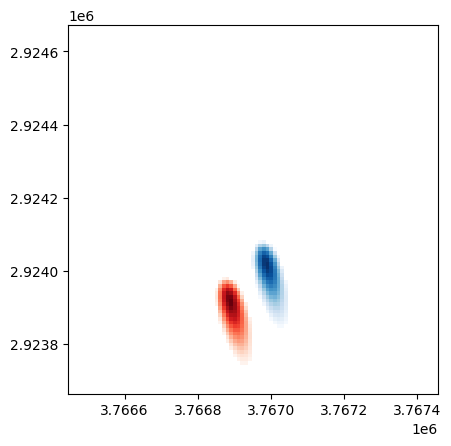

In [30]:
from rasterio.plot import show
from matplotlib import pyplot

show(np.where(tif.read(1) < 10**-5, np.nan,
         tif.read(1)), transform=tif.transform, cmap='Reds', ax=pyplot.gca())
tif = fp_tools.utils.update_affine(
    tif, c=100, f=100)
show(np.where(tif.read(1) < 10**-5, np.nan,
              tif.read(1)), transform=tif.transform, cmap='Blues', ax=pyplot.gca())

folium


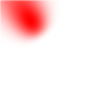

In [5]:
fp_tools.utils.plot_leaflet(nc)

# Save

to .tif

In [6]:
fp_tools.write_to_file(
    from_data.tif, 'sample/output/paris_footprint_from_data.tif')
fp_tools.write_to_file(
    from_nc.tif, 'sample/output/paris_footprint_from_nc.tif')
fp_tools.write_to_file(
    from_tif.tif, 'sample/output/paris_footprint_from_tif.tif')

to .shp

In [9]:
fp_tools.write_to_file(
    from_data.dic, 'sample/output/shp/paris_footprint_from_data.shp')
fp_tools.write_to_file(
    from_nc.dic, 'sample/output/shp/paris_footprint_from_nc.shp')
fp_tools.write_to_file(
    from_tif.dic, 'sample/output/shp/paris_footprint_from_tif.shp')

to .nc

In [7]:
fp_tools.write_to_file(
    from_data.nc, 'sample/output/paris_footprint_from_data.nc')
fp_tools.write_to_file(
    from_nc.nc, 'sample/output/paris_footprint_from_nc.nc')
fp_tools.write_to_file(
    from_tif.nc, 'sample/output/paris_footprint_from_tif.nc')

# From ICOS Data Portal to .tif

In [ ]:
# read data
data = (fp_tools.read_from_url('https://citydata.icos-cp.eu/licence_accept?ids=%5B%22BKqa7hKRd7IHGee7WHPOqMEN%22%5D', na_values=[-9999])
        .query('TIMESTAMP_START.astype("str").str.startswith("20240424")')
        .assign(TIMESTAMP=lambda x: (pd.to_datetime(x['TIMESTAMP_START'], format='%Y%m%d%H%M', utc=True)-pd.Timedelta('60Min')).dt.strftime('%y%m%d%H%M').astype(int))
        )

# calculate footprint (data -> footprint dictionary)
dic = fp_tools.calculate_footprint(
    data, by='TIMESTAMP', zm=102.5, z0=1, pblh=1500)

# convert to netcdf (dictionary -> netcdf)
crs = fp_tools.rasterio.crs.CRS.from_string('EPSG:3035')
nc = fp_tools.convert_to_nc(dic,
                            Tower_Location_Latitude=48.88514,
                            Tower_Location_Longitude=2.42222,
                            Tower_Location_CRS="EPSG:4326",
                            timestep={'timezone': 'UTC'},
                            Coordinate_Reference_System=crs.to_string(),
                            crs_projection4=crs.to_proj4(),
                            crs_wkt=crs.to_wkt())
nc['wind_dir'] = ('timestep', pd.merge(pd.DataFrame({'TIMESTAMP': nc.timestep.to_numpy()}),
                                       data[['TIMESTAMP', 'WD']], on='TIMESTAMP', how='left').WD)
fp_tools.center_footprint(nc)

# convert to tif (netcdf/dictionary -> tif)
tif = fp_tools.convert_to_tif(nc)

# save tif
fp_tools.write_to_file(
    tif, 'sample/output/paris_footprint_from_data.tif')

# plot tif
pyplot.imshow(tif.read(1), cmap='pink')
pyplot.close()